Master 2 Bioinformatique, Université Rennes 1

Antoine MONSAVOIR
Lucas   VINCENT

Notre projet de Machine Learning va consister à la prédiction de couverture nuageuse. On dispose ici de données photographiques issues de satellite et présentant la couverture nuageuse en forêt amazonienne. Le but va être de développer un algorithme permettant de classer ces images selon quatres catégories afin d'automatiser la récolte d'informations : <br /> "Temps dégagé", "Couvert", "Partiellement couvert", "Brouillard"

Pour cela nous allons utiliser un cadriciel nommé Pytorch nous permettant d'appliquer des méthodes de traitements et de manipulations utiles à l'apprentissage automatique en python. On va également devoir effectuer du traitement d'image. Pour cela nous allons réaliser des transformations afin de redimensionner les images et de les modifier pour permettre de les incorporer à notre modèle en gardant les features importantes et économiser des ressources computationnelles. Ces images, transformées en tenseurs, vont être traité par un réseau de neurones convolutifs que l'on va nous même définir. Il va s'agir d'une architecture avec 2 couches de convolutions suivi de multiples transformations linéaires. En résultats de ce réseaux va nous être renvoyé un vecteur de longeur 4 correspondant à nos 4 catégories de couverture nuageuse avec 1 en position variant selon la prédiction du programme et des 0 ailleurs.

# Construction du modèle

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from torchsampler import ImbalancedDatasetSampler
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "./"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => ./


## Importation des données

In [3]:
data_dir = './data/train'

def load_split_train_test(datadir, valid_size = .2):
    
    train_transforms = transforms.Compose([transforms.Resize(224),
                                           transforms.Grayscale(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485],
                                            std=[0.229])
                                       
                                       ])   
    test_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.Grayscale(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485],
                                            std=[0.229])
                                      ])
    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    batch_size = 64
    class_sample_count = [255908, 18821, 24293, 65369] # dataset has 10 class-1 samples, 1 class-2 samples, etc.
    weights = 1 / torch.Tensor(class_sample_count)
    weights = weights.double()
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64,
                                              sampler = ImbalancedDatasetSampler(train_data))
    
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)

print(trainloader.dataset.classes)

['clear', 'cloudy', 'haze', 'partly_cloudy']


## Architecture du modèle

In [4]:
class ModeleConv2D(nn.Module):

    def __init__(self):
        super(ModeleConv2D, self).__init__()
        # 1 input image channel, 6 output channels, 7x7 square convolution
        # kernel   

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=1*112*112, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=4)
        
    def forward(self, t):
        # (1)input layer
        t = t 
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
    
        # (4) hidden linear layer
        t = t.reshape(-1, self.num_flat_features(t))
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        # (6) output layer
        t = self.out(t)
        return t

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = ModeleConv2D()

print(model)

ModeleConv2D(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=4, bias=True)
)


In [6]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Apprentissage

In [7]:
epochs = 50
steps = 1
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
acc_hist = []

start_time = time.time()

for e in range(epochs):
    medium_time = time.time()
    train_loss = 0
    test_loss = 0
    accuracy = 0

    for images, labels in trainloader:
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images) #output 
        loss = criterion(logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    else:
        with torch.no_grad():
            imagesList = []
            labelsList = []
            model.eval()
            for images,labels in testloader:
                
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                output = logits.argmax(dim=-1)
                labelsList.extend(labels.cpu().detach().numpy().tolist())
                imagesList.extend(output.cpu().detach().numpy().tolist())
                equals = (labels == output)
                accuracy += equals.to(torch.float).mean()
                test_loss += criterion(logits, labels)
        model.train()
    print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)),
              "--- %s seconds ---" % (time.time() - medium_time))
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    acc_hist.append(accuracy/len(testloader))
    
print("Total time:",time.time() - start_time,"seconds")

Epoch: 1/50..  Training Loss: 0.815..  Test Loss: 0.659..  Test Accuracy: 0.743 --- 139.11598086357117 seconds ---
Epoch: 2/50..  Training Loss: 0.712..  Test Loss: 0.745..  Test Accuracy: 0.728 --- 137.5310182571411 seconds ---
Epoch: 3/50..  Training Loss: 0.646..  Test Loss: 0.545..  Test Accuracy: 0.804 --- 141.261479139328 seconds ---
Epoch: 4/50..  Training Loss: 0.595..  Test Loss: 0.630..  Test Accuracy: 0.772 --- 141.28135919570923 seconds ---
Epoch: 5/50..  Training Loss: 0.571..  Test Loss: 0.560..  Test Accuracy: 0.793 --- 139.16113448143005 seconds ---
Epoch: 6/50..  Training Loss: 0.541..  Test Loss: 0.511..  Test Accuracy: 0.808 --- 138.30151796340942 seconds ---
Epoch: 7/50..  Training Loss: 0.525..  Test Loss: 0.559..  Test Accuracy: 0.786 --- 140.179185628891 seconds ---
Epoch: 8/50..  Training Loss: 0.506..  Test Loss: 0.526..  Test Accuracy: 0.798 --- 139.15124535560608 seconds ---
Epoch: 9/50..  Training Loss: 0.467..  Test Loss: 0.550..  Test Accuracy: 0.786 --- 1

# Résultats

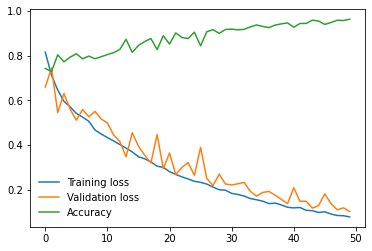

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.plot(acc_hist, label='Accuracy')
plt.legend(frameon=False)
plt.show()

Cette figure nous indique l'évolution des courbes de valeur de perte ainsi que la précision de nos prédictions. On observe dans le graphe que nos valeurs de perte diminuent tandis que la précision ne cesse de croitre. Cela reflète d'une phase d'apprentissage correcte de notre modèle.

In [9]:
print("Confusion Matrix \n")
print(confusion_matrix(labelsList, imagesList),"\n")
target_names = ["clear","cloudy","haze","partly cloudy"]
print("Classification Report \n")
print(classification_report(labelsList, imagesList, target_names = target_names))

Confusion Matrix 

[[5429   44  135   49]
 [   0  425    9    0]
 [   5   28  542    0]
 [  28    0    3 1398]] 

Classification Report 

               precision    recall  f1-score   support

        clear       0.99      0.96      0.98      5657
       cloudy       0.86      0.98      0.91       434
         haze       0.79      0.94      0.86       575
partly cloudy       0.97      0.98      0.97      1429

     accuracy                           0.96      8095
    macro avg       0.90      0.96      0.93      8095
 weighted avg       0.97      0.96      0.96      8095



Ces résultats nous présentent des métriques intéressantes à interpréter. Il est important de souligner également que l'on a plus de 5000 photos portant le label "clear" tandis que l'on en a 400 pour "cloudy" mais ceci pour le jeu de validation. Nous avions au début un jeu de donnée d'entraînement hétérogène. On a dû palier à ce problème grâce à un sampler capable d'oversampler les labels avec peu de données et au contraire d'undersampler les labels surreprésentés. Egalement lorsque l'on se base sur la précision des prédictions on remarque que le label "clear" est le plus précis. On peut expliquer ça car on travaille ici sur des photos en noir et blanc. Les nuages sont blancs ainsi une image grise va refléter d'une couverture nuageuse nulle. Le moins précis dans nos résultats est le label "haze" correspondant au brouillard. Il peut être difficile à interpréter et lorsque l'on observe la matrice de confusion on observe un bon recall mais avec peu de fiabilité, d'où la mauvaise précision. En effet le brouillard peut être léger et l'image se retrouver dans des teintes de gris clair que notre modèle va considérer comme dégagé.

# Conclusion

Les résultats obtenus démontrent un bon apprentissage de notre modèle. Cependant il reste encore améliorable. Nous avons réalisé un algorithme de prédiction sur des images en noir et blanc dans le but d'économiser des ressources et d'accélérer notre programme. Cela peut poser quelques artefacts notamment sur la prédiction de brouillard sur les photos comme on l'a vu avec le résumé de classification et la matrice de confusion. Il est possible que des images en couleurs (sur 3 channels) puissent palier à ce problème. Egalement il pourrait être intéressant d'effectuer un apprentissage sur une phase plus longue, étant donné que les courbes avaient de bons aspects. Pour finir, il serait interéssant à titre de comparaison de tester différents optimizer comme la méthode de descente de gradient stochastique ou bien d'autres fonctions de perte telle que Negative Log-Likehood Loss.